Unpack the data from pickle files


In [208]:
import pickle

with open('hw4_tr7.pkl','rb') as file:
  tr_data=pickle.load(file)

with open('hw4_te7.pkl','rb') as file:
  te_data=pickle.load(file)

Verify the dimensions of the data

In [209]:
tr_data.shape,te_data.shape

((6265, 28, 28), (1028, 28, 28))

Clean the data

In [210]:
# Process the data
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def clean_data(x):


  # Flatten the data
  samples=[]
  for sample in x[:]:
    samples.append(sample.flatten())

  x=np.array(samples)

  
  # Scale the data
  scaler=MinMaxScaler(feature_range=(0,1))

  x=scaler.fit_transform(x)

  print(x.shape)

  final_x=[]
  for i in range(len(x)):
    final_x.append(x[i].reshape(28,28))

  final_x=np.array(final_x)
  
  print(final_x.shape)


  return final_x



train_x=clean_data(tr_data)
test_x=clean_data(te_data)

(6265, 784)
(6265, 28, 28)
(1028, 784)
(1028, 28, 28)


Build the encoder to generate the latent representation of an image. For this problem, I assume the number of latent dimensions as 3. 

In [211]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D,Input,Dense,Flatten
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Sequential
from keras.initializers import HeNormal,GlorotNormal


encoder=Sequential()

Create a custom keras layer to generate samples from the normal distributions of latent variables. 

In [212]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [213]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 14, 14, 32)   320         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 4, 4, 128)    73856       conv2d_33[0][0]                  
____________________________________________________________________________________________

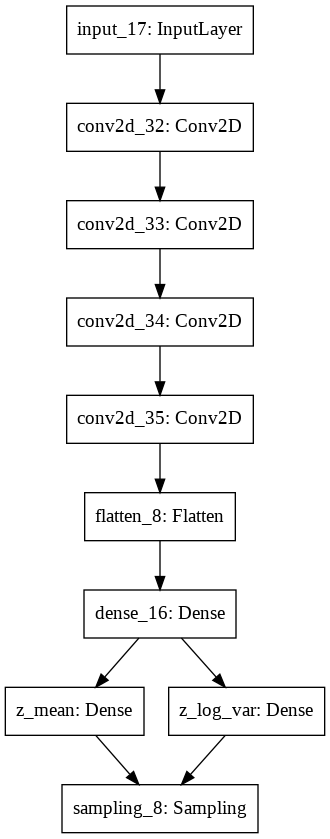

In [214]:
tf.keras.utils.plot_model(encoder)

Create a decoder which takes random samples of latent components generated by the encoder and reconstructs the input image. 

In [215]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3136)              12544     
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 28, 28, 1)         289       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_______________________________________________________

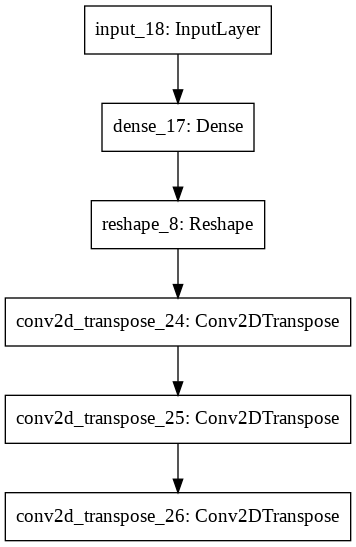

In [216]:
tf.keras.utils.plot_model(decoder)

Create a custome keras model to build the VAE model. 

In [217]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
             "kl_loss": kl_loss,
        }

In [218]:
tr_data=np.expand_dims(tr_data,axis=-1)

In [219]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Lets train the model- 

In [220]:
history=vae.fit(tr_data, epochs=100, batch_size=16,shuffle=True)

Epoch 1/100
392/392 [==============================] - 2s 5ms/step - loss: 201.2727 - reconstruction_loss: 200.1262 - kl_loss: 1.1465
Epoch 2/100
392/392 [==============================] - 2s 5ms/step - loss: 139.9482 - reconstruction_loss: 137.1644 - kl_loss: 2.7838
Epoch 3/100
392/392 [==============================] - 2s 5ms/step - loss: 133.3411 - reconstruction_loss: 130.6742 - kl_loss: 2.6669
Epoch 4/100
392/392 [==============================] - 2s 5ms/step - loss: 129.2208 - reconstruction_loss: 126.4537 - kl_loss: 2.7671
Epoch 5/100
392/392 [==============================] - 2s 5ms/step - loss: 121.4386 - reconstruction_loss: 118.2668 - kl_loss: 3.1717
Epoch 6/100
392/392 [==============================] - 2s 5ms/step - loss: 117.9285 - reconstruction_loss: 114.7010 - kl_loss: 3.2274
Epoch 7/100
392/392 [==============================] - 2s 5ms/step - loss: 115.9132 - reconstruction_loss: 112.6947 - kl_loss: 3.2185
Epoch 8/100
392/392 [==============================] - 2s 5ms/

Lets check the quality of reconstruction of our VAE model on a sample image from the test set.

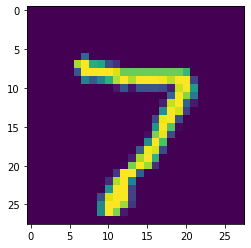

In [221]:
from matplotlib import pyplot as plt


plt.imshow((te_data[0,:,:]))

In [222]:
def gen_recon_image(image):
  
  latent_repr=encoder.predict(np.expand_dims(image,axis=(-1,0)))
  latent_sample=latent_repr[-1]
  image=np.squeeze(decoder.predict(np.expand_dims(latent_sample,axis=0)),axis=(0,-1))

  return image,latent_sample

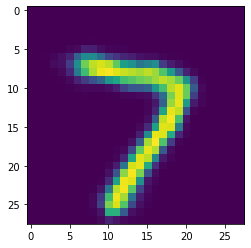

In [223]:
image,latent_sample=gen_recon_image(te_data[0,:,:])
plt.imshow(image);

Looks like our model is able to reconstruct the input image well.

Now, lets take the latent vector sample of this image and modify its components to check the effect on the reconstructed image.

Step 1: Vary the latent components individually to form the test input to the decoder.

In [224]:
test_inputs=[]


scale=5
n=20

changes = np.linspace(-scale, scale, n)

for i in range(3):
  for j in changes:
    temp=latent_sample.tolist()[0]
    temp[i]=j  
    test_inputs.append(temp)

Step 2: Reconstruct the images using the trained decoder.

In [225]:
test_inputs=np.array(test_inputs)

In [226]:
test_predictions=decoder.predict(test_inputs)

In [227]:
test_predictions=np.squeeze(test_predictions,axis=-1)

Plot the images- 

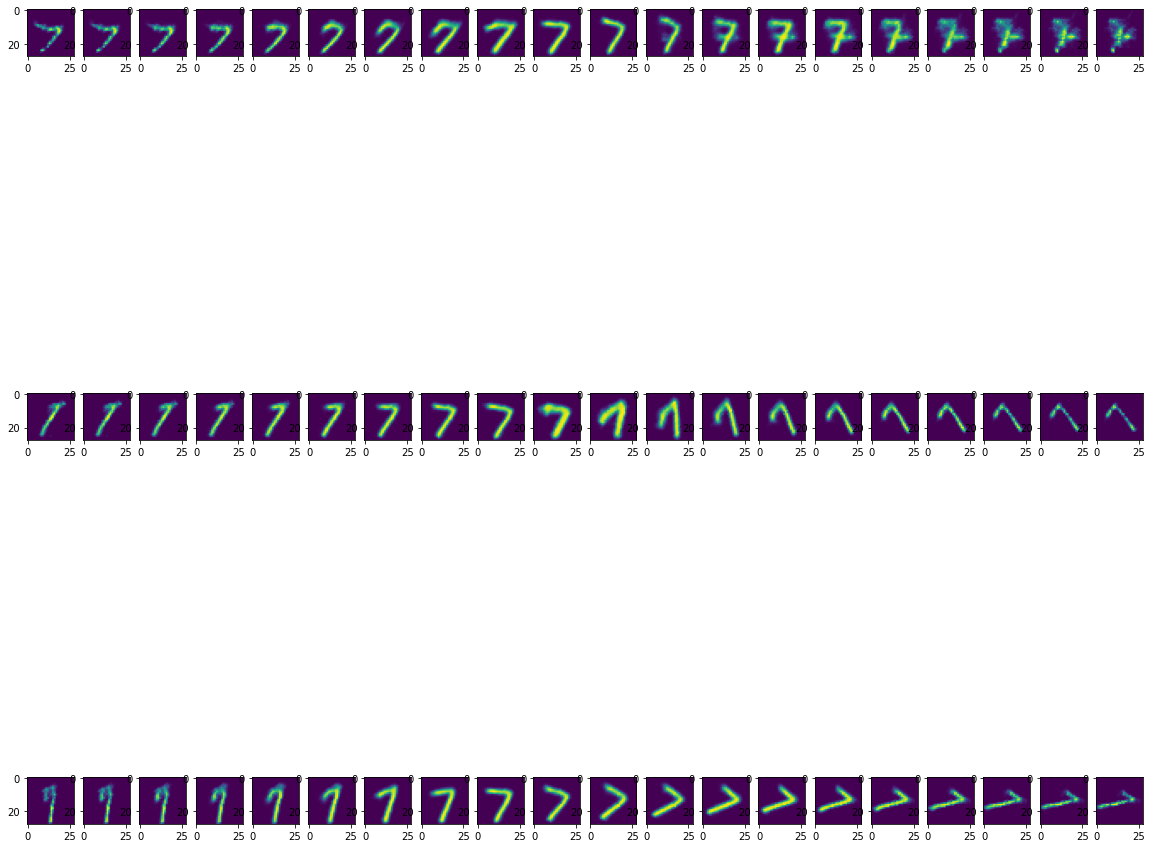

In [228]:
fig, axes=plt.subplots(nrows=3,ncols=20)
fig.set_figheight(20)
fig.set_figwidth(20)

for i in range(len(test_predictions)):
  row=i//20
  column=i%20
  axes[row,column].imshow(test_predictions[i])


Above we can see that by varying the latent dimensions, we rotate the digit and also add a horizontal bar in one dimension.  